# North Sea climatology

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd` [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1466985.svg)](https://doi.org/10.5281/zenodo.1466985)

The notebook was tested with Julia 1.1.0 but should also work with previous versions.

In [2]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
if VERSION >= v"0.7.0-beta.0"
    using Dates
    using Statistics
    using Random
    using Printf
else
    using Compat: @info, @warn, @debug
end
using Compat

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [4]:
dx, dy = 0.125, 0.125 # Resolution to modify
lonr = -5.0:dx:10.    # To check
latr = 48.:dy:62.     # To check
timerange = [Date(1900,1,1),Date(2017,12,31)]; # Used when extracting the obs

depthr = Float64.([0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000]); # Remove unuseful depth levels

# depthr = depthr[1:5]    # If you want to test on a few levels only

In [5]:
varname = "Salinity"  # Later "Temperature"
yearlist = [1900:2017]; # Add decades [1951:1960,1961:1970,] → see Simona's presentation
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]; # for seasonal climatology
# monthlist = [[i] for i = 1:12];                 # for monthly climatology

In [6]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Array{UnitRange{Int64},1},Array{Array{Int64,1},1}}(UnitRange{Int64}[1900:2017], Array{Int64,1}[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


## 1. Read your dataset
Adapt the `datadir` and `datafile` values.     
1. Download from [Sextant catalog](https://www.seadatanet.org/Products#/metadata/d9310aa6-c6b3-4657-a3c9-b0a4dd0f016c) (SeaDataCloud V1).
2. Export to ODV spreadsheet.
3. Export to netCDF.

The reading of the ODV spreadsheet is too long so we concentrate on the netCDF file generated by ODV.

### Reading from the netCDF generated by ODV
After the reading, we create a new file `obsfile` containing only the observations and the coordinates. To save time, this file has been stored on the cloud and can be downloaded.     
**Note:** standard_name attributes were added by hand ([NCO](http://nco.sourceforge.net/)) to the file with the following commands:
```bash
ncatted -O -a standard_name,longitude,o,c,longitude data_from_SDC_NS_DATA_DISCRETE_TS_V1.nc
ncatted -O -a standard_name,latitude,o,c,latitude data_from_SDC_NS_DATA_DISCRETE_TS_V1.nc
```

In [7]:
datadir = "/data/SeaDataCloud/NorthSea/"
varname = "Salinity"
obsfile = joinpath(datadir, "NorthSea_obs.nc")
netcdfODV = joinpath(datadir, "data_from_SDC_NS_DATA_DISCRETE_TS_V1b.nc")
isfile(netcdfODV)

true

In [47]:
if !isfile(obsfile)
    @info("Downloading observation file")
    download("https://dox.ulg.ac.be/index.php/s/XG2G7CBDJ4RHvFN/download", obsfile)
    
    # If you want to generate it yourself: read the ODV netCDF, then save it
    
    #@time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(
    #    Float64,
    #    netcdfODV, "Water body salinity");
    #@info("Writing the data and coordinates into an observation file")
    #DIVAnd.saveobs(obsfile,varname,obsval,
    #               (obslon, obslat, obsdepth, obstime),obsid)
    
else
    @info("Observation file already there");
end

┌ Info: Downloading observation file
└ @ Main In[47]:2
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  688M  100  688M    0     0  21.8M      0  0:00:31  0:00:31 --:--:-- 23.0M


"/data/SeaDataCloud/NorthSea/NorthSea_obs.nc"

In [48]:
@info("Reading data from the observation file")
@time obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64,obsfile,varname)
@info("Total number of data points: $(length(obsval))");

┌ Info: Reading data from the observation file
└ @ Main In[48]:1


 28.099420 seconds (23.04 M allocations: 7.059 GiB, 74.82% gc time)


┌ Info: Total number of data points: 7680899
└ @ Main In[48]:3


We ensure that the longitudes are between -180 and 180°, as it seems ODV is not taking care of that properly in the netCDF.

In [49]:
sel = obslon .> 180;
obslon[sel] = obslon[sel] .- 360.;

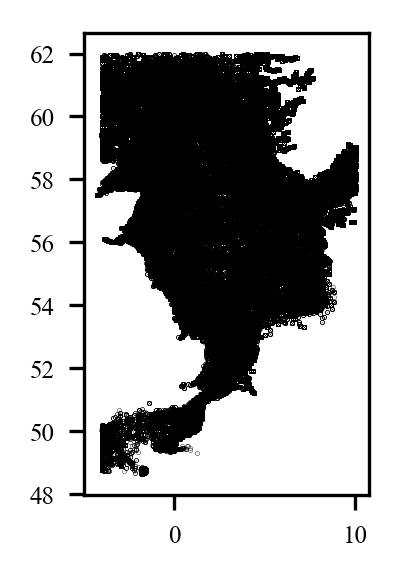

In [54]:
figure("NorthSea-Data", figsize=(2,2))
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params.("both",labelsize=6)
gca().set_aspect(aspect_ratio)

Check the extremal values of the observations

In [18]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/2RDHG/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (-4.269989013671875, 10.063799858093262)
              minimum and maximum of obs. dimension 2: (48.646331787109375, 61.9900016784668)
              minimum and maximum of obs. dimension 3: (0.0, 1632.0)
              minimum and maximum of obs. dimension 4: (1893-08-04T12:30:00, 2017-02-27T18:35:00)
                          minimum and maximum of data: (0.0, 38.19710159301758)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the grid resolution (defined by `lonr` and `latr`) required.           
The different bathymetry are stored (if needed):      
https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download →  gebco_30sec_4.nc      
https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download →  gebco_30sec_8.nc       
https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download →  gebco_30sec_16.nc      

In [25]:
bathname = joinpath(datadir, "gebco_30sec_8.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[25]:5


In [26]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  0.034957 seconds (279 allocations: 4.214 MiB)


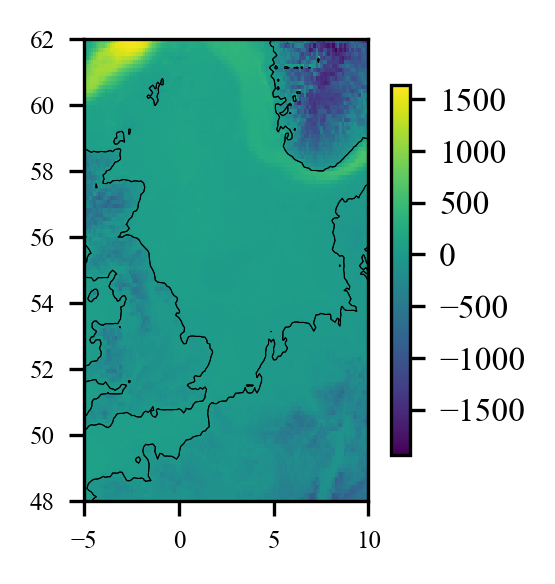

In [27]:
figure("NortSea-Bathymetry", figsize=(2,2))
ax = subplot(1,1,1)
pcolor(bx,by,permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.25)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [28]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (121, 113, 37)


(121, 113, 37)

### 2.3 Edit the mask
Remove unuseful areas.

In [30]:
#grid_bx = [i for i in bx, j in by];
#grid_by = [j for i in bx, j in by];

In [31]:
mask_edit = copy(mask);
#sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
#sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
#mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
#@show size(mask_edit)

The edited mask now looks like this:

In [ ]:
figure("NorthSea-Mask-Edited", figsize=(2,2))
ax = subplot(1,1,1)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
pcolor(bx, by, permutedims(Float64.(mask_edit[:,:,2]), [2,1])); 
gca().set_aspect(aspect_ratio)

## 3. Extract data from other sources
As an illustration we use the World Ocean Database, among other possibilities.

### 3.1 World Ocean Database

In [33]:
# Configuration
email = "ctroupin@uliege.be"
woddatadir = "/data/SeaDataCloud/NorthSea/WOD/"
mkpath(woddatadir);

In [35]:
# Uncomment the next line if you have to download the data
# This takes a very long time when the dataset is big
#WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

⌛⌛         
Read the data. This can also take up to a few minutes, depending on the size of the domain.      
In order to save time for future runs, the WOD data are also saved as an observation file and stored on the cloud.

In [50]:
obsfile_wod = joinpath(datadir, "NorthSea_obs_wod.nc")

"/data/SeaDataCloud/NorthSea/NorthSea_obs_wod.nc"

In [60]:
@time obsvalwod, obslonwod, obslatwod, obsdepthwod, obstimewod, obsidwod = 
    WorldOceanDatabase.load(Float64, woddatadir, varname);

133.683311 seconds (167.04 M allocations: 24.140 GiB, 22.38% gc time)


In [59]:
if !isfile(obsfile_wod)
    #@info("Downloading observation file")
    #download("https://dox.ulg.ac.be/index.php/s/XG2G7CBDJ4RHvFN/download", obsfile)
    
    # If you want to generate it yourself: read the ODV netCDF, then save it
    
    @time obsvalwod, obslonwod, obslatwod, obsdepthwod, obstimewod, obsidwod = 
    WorldOceanDatabase.load(Float64, woddatadir, varname);
    @info("Writing the data and coordinates into an observation file")
    DIVAnd.saveobs(obsfile_wod, varname, obsvalwod,
                  (obsvalwod, obslonwod, obslatwod, obsdepthwod, obstimewod), obsidwod)
else
    @info("Observation file already there");
end

┌ Info: Observation file already there
└ @ Main In[59]:13


In [52]:
@info("Reading data from the observation file")
@time obsvalwod, obslonwod, obslatwod, obsdepthwod, obstimewod, obsidwod = DIVAnd.loadobs(Float64,obsfile_wod,varname)
@info("Total number of data points (WOD): $(length(obsvalwod))");
@info("Total number of data points (SeaDataNet): $(length(obsval))");

┌ Info: Reading data from the observation file
└ @ Main In[52]:1


 12.976895 seconds (20.52 M allocations: 3.379 GiB, 79.33% gc time)


┌ Info: Total number of data points (WOD): 10257663
└ @ Main In[52]:3
┌ Info: Total number of data points (SeaDataNet): 7680899
└ @ Main In[52]:4


In [56]:
checkobs((obslonwod,obslatwod,obsdepthwod,obstimewod),obsvalwod,obsidwod)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/2RDHG/src/obsstat.jl:75


-1.0e10, 40.0)
              minimum and maximum of obs. dimension 2: (-5.0, 10.0)
              minimum and maximum of obs. dimension 3: (48.0, 62.0)
              minimum and maximum of obs. dimension 4: (1899-12-30T00:00:00, 1905-12-26T00:00:00)
                          minimum and maximum of data: (-1.0e10, 40.0)


In [58]:
obstimewod

10257663-element Array{DateTime,1}:
 1900-01-06T00:00:00    
 1900-01-16T00:00:00    
 1900-01-26T00:00:00    
 1900-02-05T00:00:00    
 1900-02-15T00:00:00    
 1900-02-24T00:00:00    
 1900-03-06T00:00:00    
 1900-03-16T00:00:00    
 1900-03-26T00:00:00    
 1900-04-05T00:00:00    
 1900-04-15T00:00:00    
 1900-04-25T00:00:00    
 1900-05-05T00:00:00    
 ⋮                      
 1901-01-31T11:45:29.883
 1901-03-22T07:19:14.004
 1901-05-10T14:44:16.055
 1901-06-28T21:52:12.422
 1901-08-17T18:56:36.094
 1901-10-30T01:17:10.078
 1902-01-12T23:16:08.555
 1902-03-27T09:05:11.133
 1902-06-09T20:19:07.852
 1902-09-15T17:57:58.711
 1902-12-23T04:41:57.188
 1903-03-29T05:35:23.438

Remove the data outside the region of interest (similar to mask editing) in order to avoid these data in the analysis.     
Takes time to plot... can sub-sample the vectors to save time.

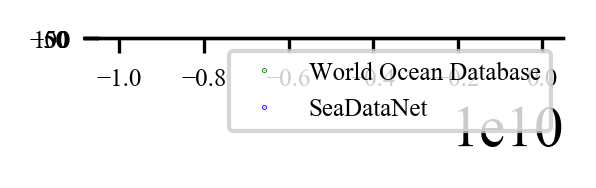

In [53]:
figure("NorthSea-WOD", figsize=(2,2))
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslonwod, obslatwod, "go", markersize=.2, 
    label="World Ocean Database");
plot(obslon, obslat, "bo", markersize=.2, 
    label="SeaDataNet")
legend(fontsize=6);
gca().set_aspect(aspect_ratio)

### 3.2 Extract from another source (optional)
Add here the code to read data from another file.

### 3.3 Remove duplicates
⌛     
Criteria (can be adapted according to the application):
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separation: 1 minute.      
* Salinity difference: 0.01 psu.      
It may take a while so we did not test it yet.

In [ ]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
    (0.01,0.01,0.01,1/(24*60)),0.01);

Find the indices of the possible duplicates:

In [ ]:
index = findall.(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(obslon) * 100; digits=2);
@info("Number of possible duplicates: $ndupl")
@info("Percentage of duplicates: $pcdupl%")

If you decide to combine the 2 (or more) datasets:

In [ ]:
newpoints = isempty.(dupl);
@info("Number of new points: " * string(sum(newpoints)))

In [ ]:
obslon = [obslon; obslonwod[newpoints]];
obslat = [obslat; obslatwod[newpoints]];
obsdepth = [obsdepth; obsdepthwod[newpoints]];
obstime = [obstime; obstimewod[newpoints]];
obsval = [obsval; obsvalwod[newpoints]];
obsid = [obsid; obsidwod[newpoints]];

Create a plot showing the additional data points:

In [ ]:
figure("Adriatic-Additional-Data", figsize=(2,2))
ax = subplot(1,1,1)
ax[:tick_params]("both",labelsize=6)
ylim(39.0, 46.0);
xlim(11.5, 20.0);
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
plot(obslonwod[newpoints], obslatwod[newpoints], "go", 
    markersize=.2, label="Additional data\nfrom World Ocean Database")
legend(loc=3, fontsize=4)
gca()[:set_aspect](aspect_ratio)

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [27]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [28]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [ ]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [48]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

### Output file name

In [30]:
filename = "Water_body_$(replace(varname," "=>"_"))_NorthSea.4Danl.nc"

"Water_body_Salinity_NorthSea.4Danl.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [31]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Serge Scory <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

SeaDataNet global attributes:

In [32]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(OrderedDict("project"=>"SeaDataCloud","institution"=>"University of Liege, GeoHydrodynamics and Environment Research","institution_urn"=>"SDN:EDMO::1579","Author_e-mail"=>"Serge Scory <name1@example.com>, Other Name <name2@example.com>","source"=>"observational data from SeaDataNet and World Ocean Atlas","comment"=>"Duplicate removal applied to the merged dataset","parameter_keyword"=>"Water body salinity","parameter_keyword_urn"=>"SDN:P35::EPC00001","search_keywords"=>"Salinity of the water column","search_keywords_urn"=>"SDN:P02::PSAL"…), OrderedDict("units"=>"1e-3","standard_name"=>"sea_water_salinity","long_name"=>"sea water salinity"))

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [33]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [35]:
figdir = "NorthSea/figures/"
if ~(isdir(figdir))
    mkpath(figdir)
else
    @info("Figure directory already exists")
end

"NorthSea/figures"

In [44]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("", figsize=(2,2))
        ax = subplot(1,1,1)
        ax[:tick_params]("both",labelsize=6)
       
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]))
        colorbar(extend="both", orientation="vertical", shrink=0.8)[:ax][:tick_params](labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca()[:set_aspect](aspect_ratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [51]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask_edit,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    MEMTOFIT=100,
    solver=:direct
    );

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/H9TBj/src/diva.jl:297
┌ Info: Time step 1 / 4
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/H9TBj/src/diva.jl:334
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/H9TBj/src/DIVAndgo.jl:89
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/H9TBj/src/DIVAndgo.jl:89
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotres(::Int64, ::BitArray{1}, ::Array{Float64,3}, ::Array{Float32,3}) at In[44]:7
└ @ Main ./In[44]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotres(::Int64, ::BitArray{1}, ::Array{Float64,3}, ::Array{Float32,3}) at In[44]:11
└ @ Main ./In[44]:11
┌ Warning: `getin

 86.549038 seconds (271.64 k allocations: 28.382 GiB, 57.07% gc time)


Save the observation metadata in the NetCDF file.      
⚠️ The WOD observations IDs have to be modified in order to be ingested by the XML generation ([Step 9](http://localhost:8888/notebooks/90-full-analysis.ipynb#9.-XML-metadata)): to this end, we add the EDMO code of the [U.S. NODC](http://seadatanet.maris2.nl/v_edmo/print.asp?order=&step=003nodc_00043_0021&count=0&n_code=1977&page_size=50&markers_show=1&map=1&oldorder=name&desc=0), which is 1977.

In [52]:
obsidlist = copy(obsid);
for i in 1:length(obsidlist)
    if occursin("wod_", obsidlist[i])
        obsidlist[i] = replace(obsidlist[i], "wod_"=>"1977-wod_")
    end
end;

In [53]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsidlist);

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [ ]:
project = "SeaDataCloud";
project = "EMODNET-chemistry"

Download CDI list

In [ ]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by underscores)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant catalog
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)